# Algoritmo de resolução do problema das 8 rainhas

In [1]:
import random
import copy
import numpy as np
import statistics
import matplotlib.pyplot as plt

### Inicialização da população
A população é um vetor de indivíduos. Cada indivíduo é criado, inicialmente, como um vetor de permutação dos números 0 a 7 em decimal. Depois, ele é convertido para uma matriz na qual cada linha representa um dos números em formato binário.

In [41]:
def init_populacao(tamanho):
    populacao = []
    populacao_decimal = []
    for _ in range(tamanho):
        individuo = random.sample(range(0, 8), 8)
        populacao_decimal.append(individuo)
        individuo_binario = []
        for x in individuo:
          binario = format(x, '03b')
          linha = [int(digito) for digito in binario]
          individuo_binario.append(linha)
        populacao.append(individuo_binario)
    print(f'Tamanho da população inicializada: {len(populacao)}')
    print(f'População: {populacao}')
    return populacao

### Função de fitness
O máximo de colisões possíveis entre rainhas é 28, quando todas elas estão na mesma diagonal (a primeira colide em 7, a segunda em 6, a terceira em 5 e por aí vai). Sabendo disso, calculamos a quantidade de colisões para um indivíduo e subtraímos de 28, sendo 28 o melhor fitness e 0 o pior.

O cálculo de colisões de um indivíduo é feito comparando a posição entre 2 rainhas e os respectivos índices no tabuleiro. Se o valor absoluto da subtração entre as linhas das rainhas for igual ao valor absoluto da subtração das colunas, então as rainhas estão na mesma diagonal, o que significa que há colisão entre elas.

In [42]:
def binario_para_decimal(individuo):
  individuo_decimal = []
  for linha in individuo:
      string_binaria = ''.join(str(bit) for bit in linha)
      valor_decimal = int(string_binaria, 2)
      individuo_decimal.append(valor_decimal)
  return individuo_decimal

In [43]:
def calcular_fitness(individuo):
    conflitos = 0
    individuo = binario_para_decimal(individuo)
    for i in range(len(individuo)):
        for j in range(i + 1, len(individuo)):
            if abs(individuo[i] - individuo[j]) == abs(i - j):
                conflitos += 1
    return 28 - conflitos

### Seleção de pais
Seleção por torneio, na qual são selecionados 5 indivíduos aleatórios da população e, dentre eles, seleciona os 2 com maior fitness.

In [44]:
def selecao_pais(populacao):
    selecionados = random.sample(populacao, 5)
    selecionados = sorted(selecionados, key=calcular_fitness, reverse=True)
    selecionados = selecionados[:2]
    return selecionados

### Crossover
Se o fine tuning não estiver ativado, então há 90% de chances de acontecer uma recombinação, na qual o crosspoint é após os 3 primeiros genes. Já se o fine tuning estiver ativado, então a probabilidade de acontecer uma recombinação é de 15%.

In [45]:
def gerar_filho(crosspoint, filho, pai):
  for i in range(crosspoint, len(pai)):
        if len(filho) == len(pai):
            break
        if pai[i] not in filho:
            filho.append(pai[i])

  if len(filho) < len(pai):
        for i in range(crosspoint):
            if len(filho) == len(pai):
                break
            if pai[i] not in filho:
                filho.append(pai[i])
  return filho

In [46]:
def crossover(pai1, pai2, fine_tuning):
    if not fine_tuning:
      if random.random() <= 0.9:
        crosspoint = 3

        filho1 = pai1[:crosspoint]
        filho2 = pai2[:crosspoint]

        filho1 = gerar_filho(crosspoint, filho1, pai2)
        filho2 = gerar_filho(crosspoint, filho2, pai1)

      else:
        filho1 = pai1
        filho2 = pai2

    else:
      if random.random() <= 0.15:
        crosspoint = 3

        filho1 = pai1[:crosspoint]
        filho2 = pai2[:crosspoint]

        filho1 = gerar_filho(crosspoint, filho1, pai2)
        filho2 = gerar_filho(crosspoint, filho2, pai1)

      else:
        filho1 = pai1
        filho2 = pai2

    return filho1, filho2

### Mutação
Se o fine tuning não estiver ativado, então a probabilidade de mutação é de 40%. Já se ele estiver ativado, a probabilidade é de 60%.

In [47]:
def mutacao(individuo, fine_tuning):
    individuo_mutado = copy.deepcopy(individuo)
    if not fine_tuning:
      if random.random() <= 0.4:
          gene1, gene2 = random.sample(range(8), 2)
          individuo_mutado[gene1], individuo_mutado[gene2] = individuo_mutado[gene2], individuo_mutado[gene1]
    else:
      if random.random() <= 0.6:
          gene1, gene2 = random.sample(range(8), 2)
          individuo_mutado[gene1], individuo_mutado[gene2] = individuo_mutado[gene2], individuo_mutado[gene1]
    return individuo_mutado

### Seleção de sobreviventes
O método usada é elitista, com o objetivo de sempre aumentar o fitness médio da população. Após serem gerados os filhos e suas respectivas mutações, então checamos se o fitness deles é maior que os piores indivíduos da população já existente. Se sim, então substituímos os piores pelos filhos e, se não, deixamos a população como está.

In [48]:
def selecao_sobreviventes(populacao, filho1, filho2):
  fitness1 = calcular_fitness(filho1)
  fitness2 = calcular_fitness(filho2)

  populacao_ordenada = sorted(populacao, key=calcular_fitness, reverse=True)

  if (fitness1 > fitness2):
    if (fitness1 > calcular_fitness(populacao_ordenada[-2])):
        if (fitness2 > calcular_fitness(populacao_ordenada[-1])): # Coloca os dois filhos na população
          populacao_ordenada[-1] = filho2
          populacao_ordenada[-2] = filho1
        else: # O pior filho não pode entrar na população
          populacao_ordenada[-1] = filho1
    else:
      if (fitness1 > calcular_fitness(populacao_ordenada[-1])): # O melhor filho só é melhor que o pior da população
        populacao_ordenada[-1] = filho1
  else:
    if (fitness2 > calcular_fitness(populacao_ordenada[-2])):
        if (fitness1 > calcular_fitness(populacao_ordenada[-1])):
          populacao_ordenada[-1] = filho1
          populacao_ordenada[-2] = filho2
        else:
          populacao_ordenada[-1] = filho2
    else:
      if (fitness2 > calcular_fitness(populacao_ordenada[-1])):
        populacao_ordenada[-1] = filho2

  return populacao_ordenada

### Análises estatísticas do fitness da população
Obtém o melhor indivíduo, o pior, seus valores de fitness, fitness médio, desvio padrão e todos os valores de fitness da população.

In [49]:
def analise_fitness(populacao):
  populacao_ordenada = sorted(populacao, key=calcular_fitness, reverse=True)
  melhor_individuo = populacao_ordenada[0]
  pior_individuo = populacao_ordenada[-1]
  melhor_fitness = calcular_fitness(melhor_individuo)
  pior_fitness = calcular_fitness(pior_individuo)
  fitness_geral = [calcular_fitness(populacao[i]) for i in range(len(populacao))]
  fitness_medio = sum(fitness_geral)/len(fitness_geral)
  fitness_dp = statistics.stdev(fitness_geral)
  return melhor_individuo, melhor_fitness, pior_individuo, pior_fitness, fitness_medio, fitness_dp, fitness_geral

### Algoritmo até primeiro indivíduo convergir

In [164]:
populacao = init_populacao(100)
melhor_individuo, melhor_fitness, pior_individuo, pior_fitness, fitness_medio, fitness_dp, fitness_geral = analise_fitness(populacao)
print(f'Melhor fitness da população incial: {melhor_fitness}')
print(f'Pior fitness da população inicial: {pior_fitness}')
print(f'Fitness médio da população inicial: {fitness_medio}')
print(f'Desvio padrão da população inicial: {fitness_dp}\n')
geracao = 0
media_por_geracao = []
melhor_individuo_geracao = []
fine_tuning = False

while geracao < 10000:
    pais = selecao_pais(populacao)
    filho1, filho2 = crossover(pais[0], pais[1], fine_tuning)
    filho1 = mutacao(filho1, fine_tuning)
    filho2 = mutacao(filho2, fine_tuning)

    populacao = selecao_sobreviventes(populacao, filho1, filho2)

    geracao += 1

    melhor_individuo, melhor_fitness, pior_individuo, pior_fitness, fitness_medio, fitness_dp, fitness_geral = analise_fitness(populacao)

    print(f'Melhor fitness da geração {geracao}: {melhor_fitness}')
    print(f'Pior fitness da geração {geracao}: {pior_fitness}')
    print(f'Fitness médio da geração {geracao}: {fitness_medio}')
    print(f'Desvio padrão da geração {geracao}: {fitness_dp}')

    media_por_geracao.append(fitness_medio)
    melhor_individuo_geracao.append(melhor_fitness)

    if fitness_medio >= 27 and not fine_tuning:
      print(f'\nFine tuning ativado!\n')
      fine_tuning = True

    if melhor_fitness == 28:
      print(f'\nO algoritmo convergiu!\n')
      break

print(f"Quantidade de gerações para convergir: {geracao}")
print(f'Quantos indivíduos convergiram: {fitness_geral.count(28)}')
print(f"Melhor indivíduo encontrado: {melhor_individuo}")
print(f"Pior indivíduo encontrado: {pior_individuo}")
print(f"Melhor fitness encontrado: {melhor_fitness}")
print(f"Pior fitness encontrado: {pior_fitness}")
print(f"Fitness médio quando convergiu: {fitness_medio}")
print(f"Desvio padrão do fitness quando convergiu: {fitness_dp}")

print(f"\nAgora o algoritmo continua até todos convergirem...")

Tamanho da população inicializada: 100
População: [[[0, 1, 0], [1, 1, 1], [0, 0, 0], [1, 1, 0], [1, 0, 0], [0, 1, 1], [0, 0, 1], [1, 0, 1]], [[1, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 0, 1], [0, 0, 0], [1, 1, 1]], [[1, 0, 1], [1, 1, 0], [1, 0, 0], [0, 0, 0], [0, 1, 1], [0, 1, 0], [0, 0, 1], [1, 1, 1]], [[0, 1, 0], [1, 1, 0], [1, 1, 1], [1, 0, 1], [0, 0, 0], [1, 0, 0], [0, 0, 1], [0, 1, 1]], [[1, 0, 1], [0, 0, 0], [1, 1, 0], [0, 0, 1], [0, 1, 1], [1, 1, 1], [0, 1, 0], [1, 0, 0]], [[1, 0, 0], [0, 1, 1], [1, 1, 0], [0, 0, 0], [1, 0, 1], [1, 1, 1], [0, 1, 0], [0, 0, 1]], [[1, 1, 0], [0, 1, 0], [0, 0, 0], [1, 1, 1], [1, 0, 1], [0, 0, 1], [0, 1, 1], [1, 0, 0]], [[1, 0, 0], [0, 1, 0], [1, 0, 1], [0, 1, 1], [0, 0, 1], [0, 0, 0], [1, 1, 1], [1, 1, 0]], [[0, 0, 1], [0, 0, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [1, 1, 1], [1, 1, 0]], [[0, 0, 0], [1, 1, 1], [0, 1, 1], [1, 1, 0], [0, 1, 0], [1, 0, 1], [0, 0, 1], [1, 0, 0]], [[0, 1, 1], [0, 0, 0], [1, 0, 1], [1, 1, 0], [1, 

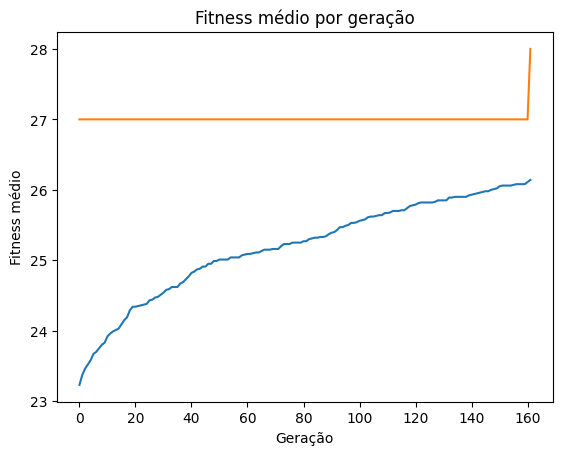

In [165]:
plt.plot(media_por_geracao)
plt.plot(melhor_individuo_geracao)
plt.xlabel('Geração')
plt.ylabel('Fitness médio')
plt.title('Fitness médio por geração')
plt.show()

### Continuação do algoritmo até todos os indivíduos convergirem

In [166]:
media_por_geracao = []
melhor_individuo_geracao = []

while pior_fitness < 28 and geracao < 10000:
    pais = selecao_pais(populacao)
    filho1, filho2 = crossover(pais[0], pais[1], fine_tuning)
    filho1 = mutacao(filho1, fine_tuning)
    filho2 = mutacao(filho2, fine_tuning)

    populacao = selecao_sobreviventes(populacao, filho1, filho2)

    geracao += 1

    melhor_individuo, melhor_fitness, pior_individuo, pior_fitness, fitness_medio, fitness_dp, fitness_geral = analise_fitness(populacao)

    print(f'Melhor fitness da geração {geracao}: {melhor_fitness}')
    print(f'Pior fitness da geração {geracao}: {pior_fitness}')
    print(f'Fitness médio da geração {geracao}: {fitness_medio}')
    print(f'Desvio padrão da geração {geracao}: {fitness_dp}')

    media_por_geracao.append(fitness_medio)
    melhor_individuo_geracao.append(melhor_fitness)

    if fitness_medio >= 27 and not fine_tuning:
      print(f'\nFine tuning ativado!\n')
      fine_tuning = True

print(f"Quantidade de gerações para toda a população convergir: {geracao}")


Melhor fitness da geração 163: 28
Pior fitness da geração 163: 25
Fitness médio da geração 163: 26.14
Desvio padrão da geração 163: 0.6033576087532203
Melhor fitness da geração 164: 28
Pior fitness da geração 164: 25
Fitness médio da geração 164: 26.18
Desvio padrão da geração 164: 0.5925462944877059
Melhor fitness da geração 165: 28
Pior fitness da geração 165: 25
Fitness médio da geração 165: 26.22
Desvio padrão da geração 165: 0.5787482137765049
Melhor fitness da geração 166: 28
Pior fitness da geração 166: 25
Fitness médio da geração 166: 26.23
Desvio padrão da geração 166: 0.5659532050470518
Melhor fitness da geração 167: 28
Pior fitness da geração 167: 25
Fitness médio da geração 167: 26.24
Desvio padrão da geração 167: 0.5526794237662059
Melhor fitness da geração 168: 28
Pior fitness da geração 168: 25
Fitness médio da geração 168: 26.24
Desvio padrão da geração 168: 0.5526794237662059
Melhor fitness da geração 169: 28
Pior fitness da geração 169: 25
Fitness médio da geração 169

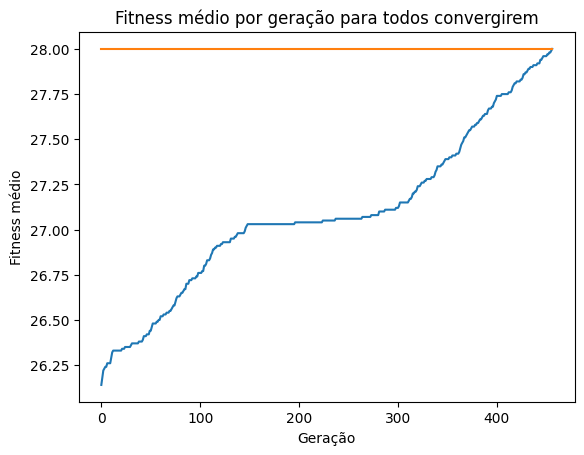

In [167]:
plt.plot(media_por_geracao)
plt.plot(melhor_individuo_geracao)
plt.xlabel('Geração')
plt.ylabel('Fitness médio')
plt.title('Fitness médio por geração para todos convergirem')
plt.show()